In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import gridmeter as gm

from copy import deepcopy as copy

import matplotlib as mpl
import matplotlib.pyplot as plt

from timeit import default_timer as timer

In [35]:
miss_fracs = np.arange(0, 0.55, 0.05)
# range of numbers from 5 to 45, with a step of 2 must include 45


np.arange(0, 0.55, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [3]:
# pip install qpsolvers[opensource]
# pip install cvxpy[CBC,CLARABEL,COPT,DAQP,GLOP,GLPK,GLPK_MI,OSQP,PIQP,PROXQP,PDLP,CPLEX,NAG,ECOS,GUROBI,MOSEK,CVXOPT,SDPA,SCS,SCIP,XPRESS]

In [4]:
# Load and assign data

# data_type = "month_loadshape"
# data_type = "seasonal_day_of_week_loadshape"
data_type = "seasonal_hourly_day_of_week_loadshape"

df_ls_all = gm.load_tutorial_data(data_type)

# randomly generate treatment and control groups
def generate_data(df_ls_all):
    # randomly select 100 ids from df_ls_all
    all_ids = df_ls_all.index.to_list()
    t_ids = np.random.choice(all_ids, 100, replace=False)

    df_ls_treatment = df_ls_all.loc[t_ids]
    treatment_data = gm.Data(loadshape_df=df_ls_treatment)

    # remove t_ids from all_ids
    all_ids = [x for x in all_ids if x not in t_ids]
    cp_ids = np.random.choice(all_ids, 1000, replace=False)

    df_ls_pool = df_ls_all.loc[cp_ids]
    pool_data = gm.Data(loadshape_df=df_ls_pool)

    return treatment_data, pool_data

In [5]:
n_matches_per_treatment = 3
allow_duplicates = False
distance_metric = "euclidean"
# distance_metric = "cosine"
    
max_distance_threshold = None
n_meters_per_chunk = 10000

def fit_IMM(treatment_data, pool_data, method="legacy"):
    settings = gm.IMM_Settings(
        SELECTION_METHOD=method,
        N_MATCHES_PER_TREATMENT=n_matches_per_treatment,
        DISTANCE_METRIC=distance_metric,
        ALLOW_DUPLICATE_MATCHES=allow_duplicates,
        N_TREATMENTS_PER_CHUNK=n_meters_per_chunk,
    )
    imm = gm.IMM(settings)

    start = timer()
    df_cg, df_t_coeffs = imm.get_comparison_group(treatment_data, pool_data)
    time = timer() - start

    return imm.get_loadshapes(), df_cg, df_t_coeffs, time

def fit_clustering(treatment_data, pool_data, method="custom"):
    settings = gm.Clustering_Settings()
    clustering = gm.Clustering(settings)

    start = timer()
    df_cg, df_t_coeffs = clustering.get_comparison_group(treatment_data, pool_data)
    time = timer() - start

    return clustering.get_loadshapes(), df_cg, df_t_coeffs, time

def fit_compare(treatment_data, pool_data, method="IMM"):
    if method == "IMM":
        ls_old, df_cg_old, old_time = fit_IMM(treatment_data, pool_data, method="legacy")
        ls_new, df_cg_new, new_time = fit_IMM(treatment_data, pool_data, method="minimize_meter_distance")
    else:
        ls_old, df_cg_old, df_t_coeffs_old, old_time = fit_clustering(treatment_data, pool_data, method="custom")
        ls_new, df_cg_new, df_t_coeffs_new, new_time = fit_clustering(treatment_data, pool_data, method="highs")

    old_rmse = (np.sum((ls_old.loc["Comparison Group"] - ls_old.loc["Treatment Group"])**2))**0.5
    new_rmse = (np.sum((ls_new.loc["Comparison Group"] - ls_new.loc["Treatment Group"])**2))**0.5

    return old_rmse, new_rmse, old_time, new_time


In [6]:
n = 0
method = "IMM"
# method = "clustering"

res = []
for i in range(n):
    treatment_data, pool_data = generate_data(df_ls_all)
    res.append(fit_compare(treatment_data, pool_data, method=method))

    if i % 10 == 0:
        print(i)

df_res = pd.DataFrame(res, columns=["Old RMSE", "New RMSE", "Old Time", "New Time"])
df_res["RMSE improvement"] = (df_res["Old RMSE"] - df_res["New RMSE"]) / df_res["Old RMSE"]
df_res["Time improvement"] = (df_res["Old Time"] - df_res["New Time"]) / df_res["Old Time"]
df_res[["RMSE improvement", "Time improvement"]].mean()

RMSE improvement    NaN
Time improvement    NaN
dtype: object

-1186850.1


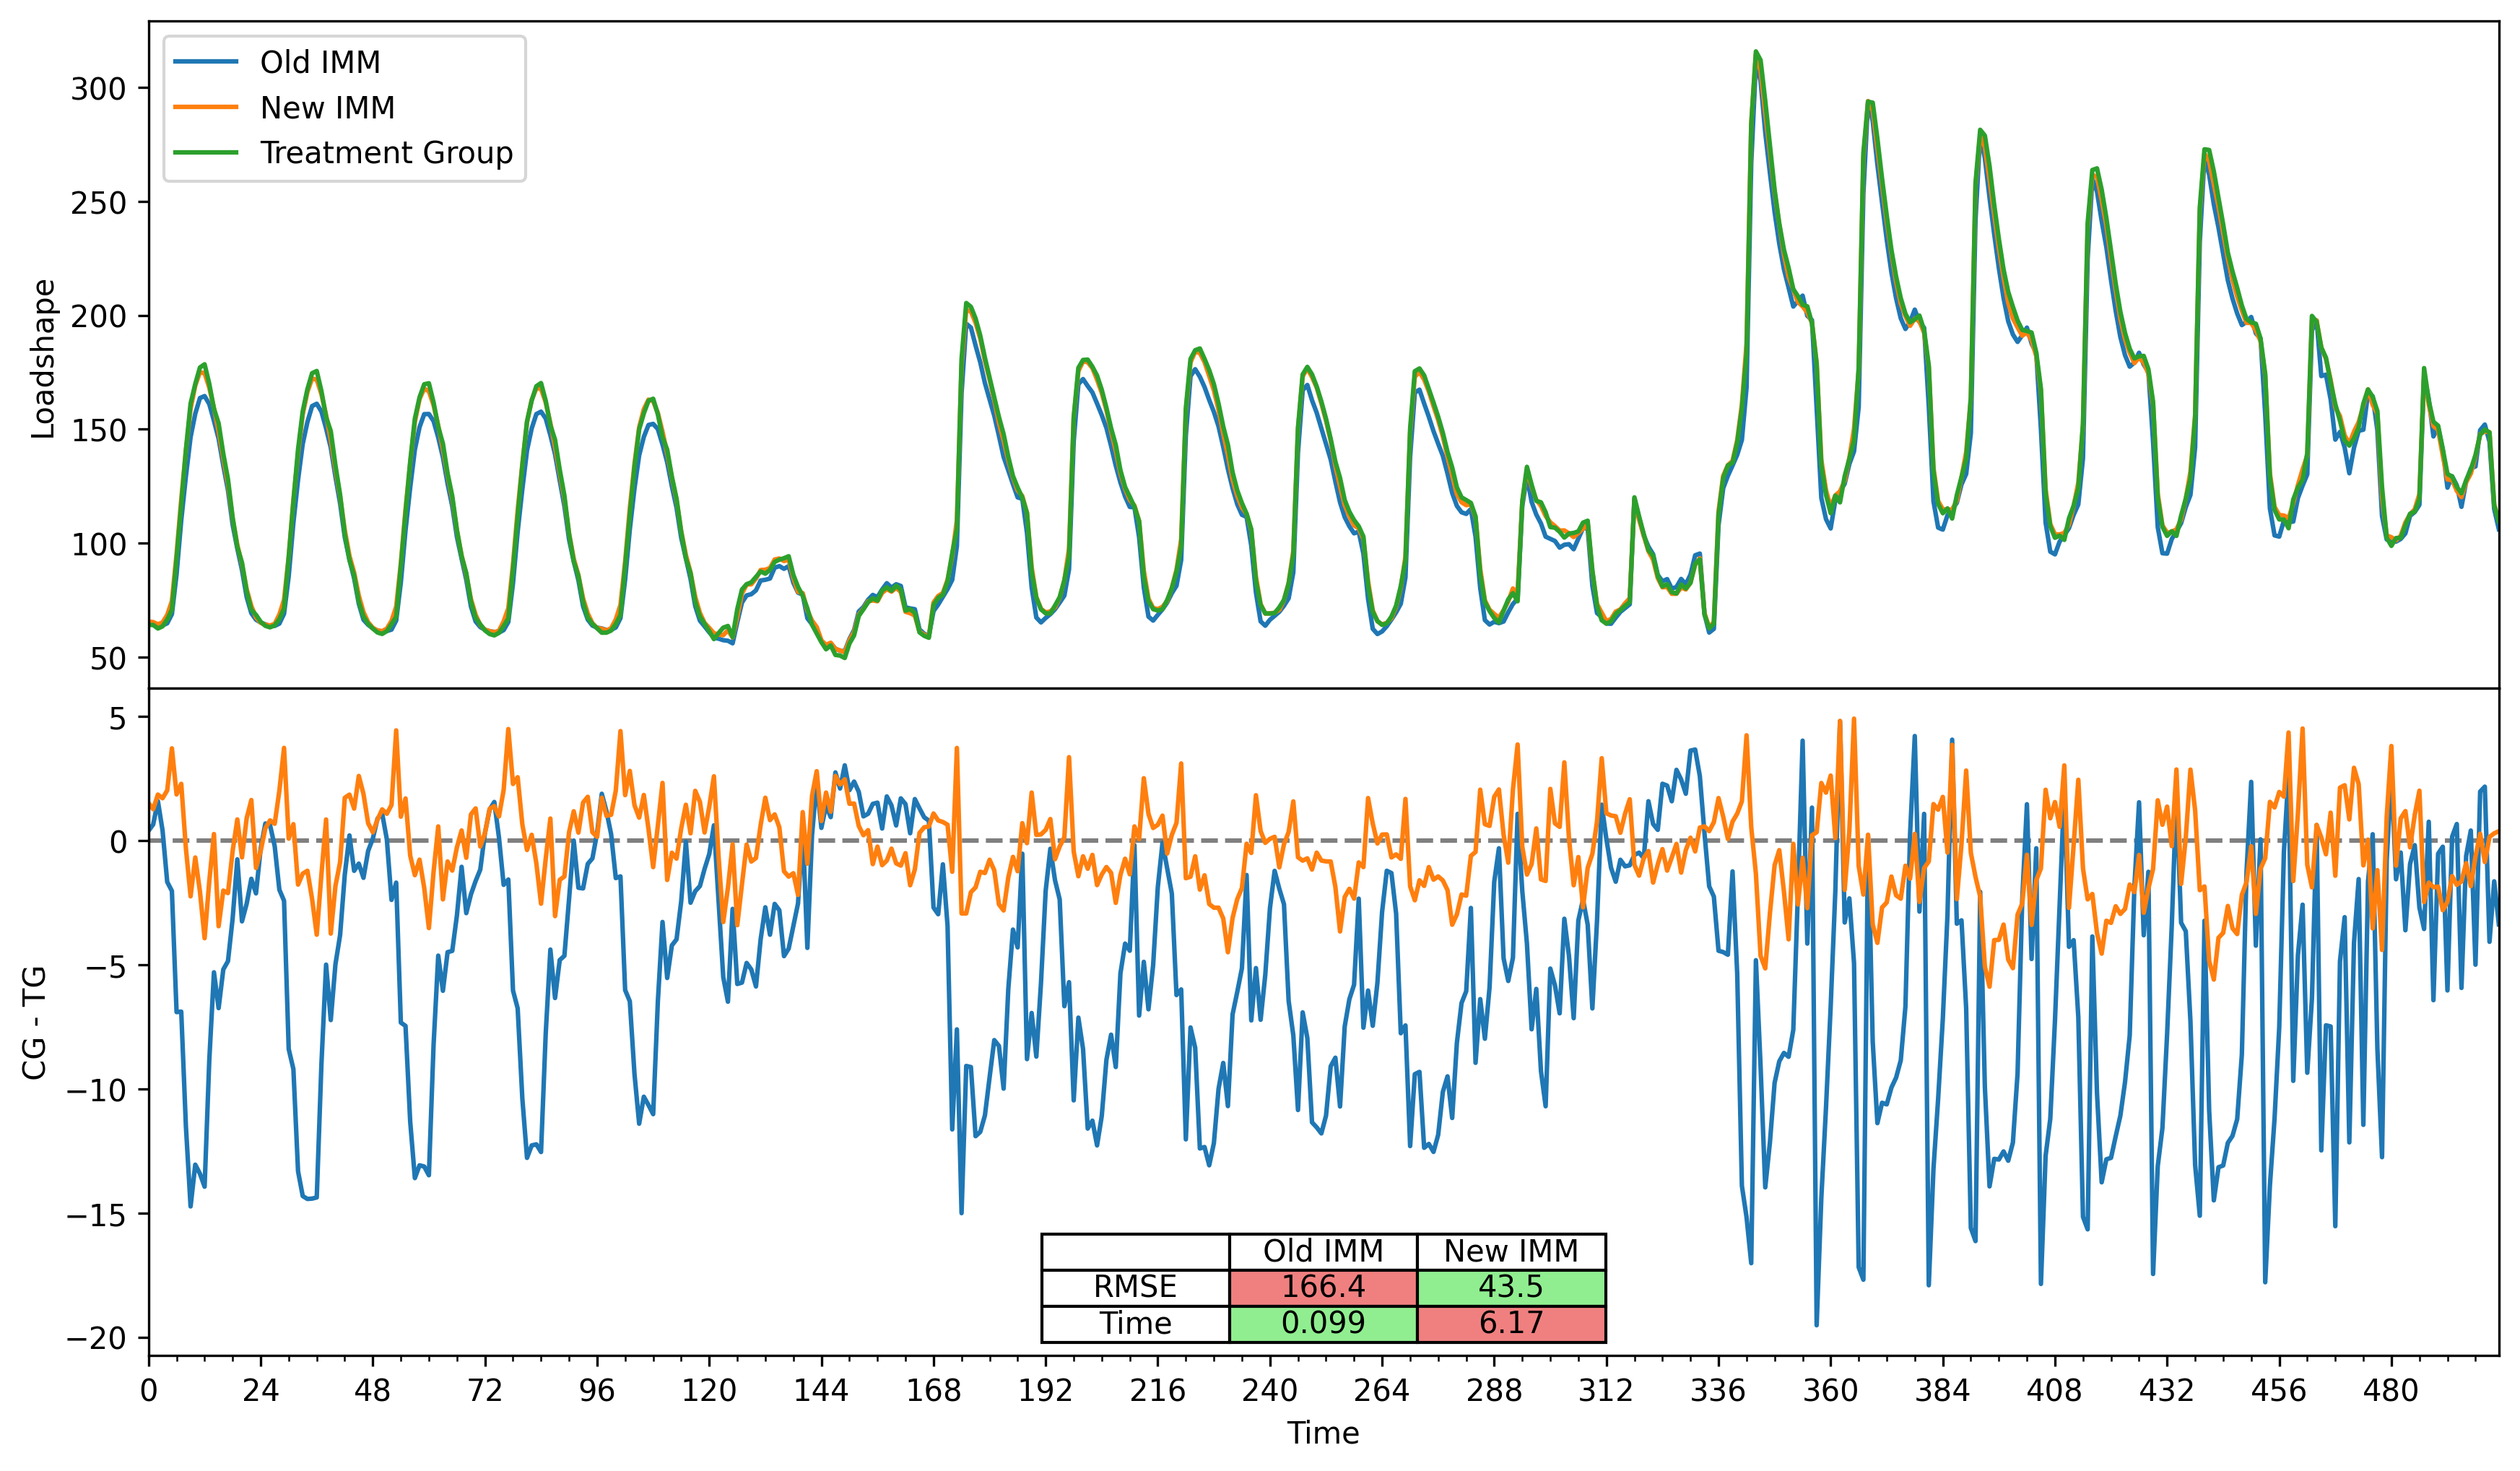

In [10]:
treatment_data, pool_data = generate_data(df_ls_all)
# 
ls_old, df_cg_old, df_t_coeffs_old, old_time = fit_IMM(treatment_data, pool_data, method="legacy")
# ls_new, df_cg_new, df_t_coeffs_new, new_time = fit_IMM(treatment_data, pool_data, method="minimize_meter_distance")
ls_new, df_cg_new, df_t_coeffs_new, new_time = fit_IMM(treatment_data, pool_data, method="minimize_loadshape_distance")

# ls_old, df_cg_old, df_t_coeffs_old, old_time = fit_clustering(treatment_data, pool_data, method="custom")
# ls_new, df_cg_new, df_t_coeffs_new, new_time = fit_clustering(treatment_data, pool_data, method="highs")

# plot treatment group in ls_old and all of ls_new using matplotlib in one figure
t_min = ls_new.T.index[0]
t_max = ls_new.T.index[-1]

# plot ls
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), dpi=300)
plt.subplots_adjust(hspace=0)

ax1.plot(ls_old.T.index, ls_old.T["Comparison Group"], label="Old IMM")
ax1.plot(ls_new.T.index, ls_new.T["Comparison Group"], label="New IMM")
ax1.plot(ls_new.T.index, ls_new.T["Treatment Group"], label="Treatment Group")
# ax1.plot(ls_new.T.index, ls_new.T["Comparison Pool"], label="Comparison Pool", color="black", alpha=0.5)

ax1.set_xticks([])
ax1.set_ylabel('Loadshape')
ax1.legend()

# make ax2 plot the difference between the two loadshapes
ax2.axhline(0, linestyle="--", color="black", alpha=0.5)
ax2.plot(ls_new.T.index, ls_old.T["Comparison Group"] - ls_old.T["Treatment Group"], label="Old IMM")
ax2.plot(ls_new.T.index, ls_new.T["Comparison Group"] - ls_new.T["Treatment Group"], label="New IMM")

if (t_max - t_min) % 24 and (t_max - t_min) > 24:
    ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    ax2.set_xticks(np.arange(t_min, t_max, 24))

ax2.set_xlabel('Time')
ax2.set_ylabel('CG - TG')

ax1.set_xlim([t_min, t_max])
ax2.set_xlim([t_min, t_max])

# add RMSE to plot next to legend
# get y limits of ax2
y_min, y_max = ax2.get_ylim()
x_txt = (t_max-t_min)/2
y_txt = (y_max - y_min) * 0.9 + y_min

# compute rmse of ls_new old and new "treatment_group vs. comparison_group"
old_rmse = (np.sum((ls_old.loc["Comparison Group"] - ls_old.loc["Treatment Group"])**2))**0.5
new_rmse = (np.sum((ls_new.loc["Comparison Group"] - ls_new.loc["Treatment Group"])**2))**0.5

# plot table of RMSE and time using latex
table_data = [
    ["RMSE", round(old_rmse, 1), round(new_rmse, 1)],
    ["Time", round(old_time, 3), round(new_time, 3)]
]

width = 0.08
table = ax2.table(cellText=table_data, colLabels=["", "Old IMM", "New IMM"], cellLoc="center", loc=7, colWidths=[width]*3, zorder=99)

# color cell in RMSE row with green if new RMSE is lower
if new_rmse < old_rmse:
    table[(1, 1)].set_facecolor("lightcoral")
    table[(1, 2)].set_facecolor("lightgreen")
else:
    table[(1, 1)].set_facecolor("lightgreen")
    table[(1, 2)].set_facecolor("lightcoral")

if old_time > new_time:
    table[(2, 1)].set_facecolor("lightcoral")
    table[(2, 2)].set_facecolor("lightgreen")
else:
    table[(2, 1)].set_facecolor("lightgreen")
    table[(2, 2)].set_facecolor("lightcoral")

print(f"{df_cg_old['distance'].sum() - df_cg_new['distance'].sum():.1f}")

fig.show()

3432.4


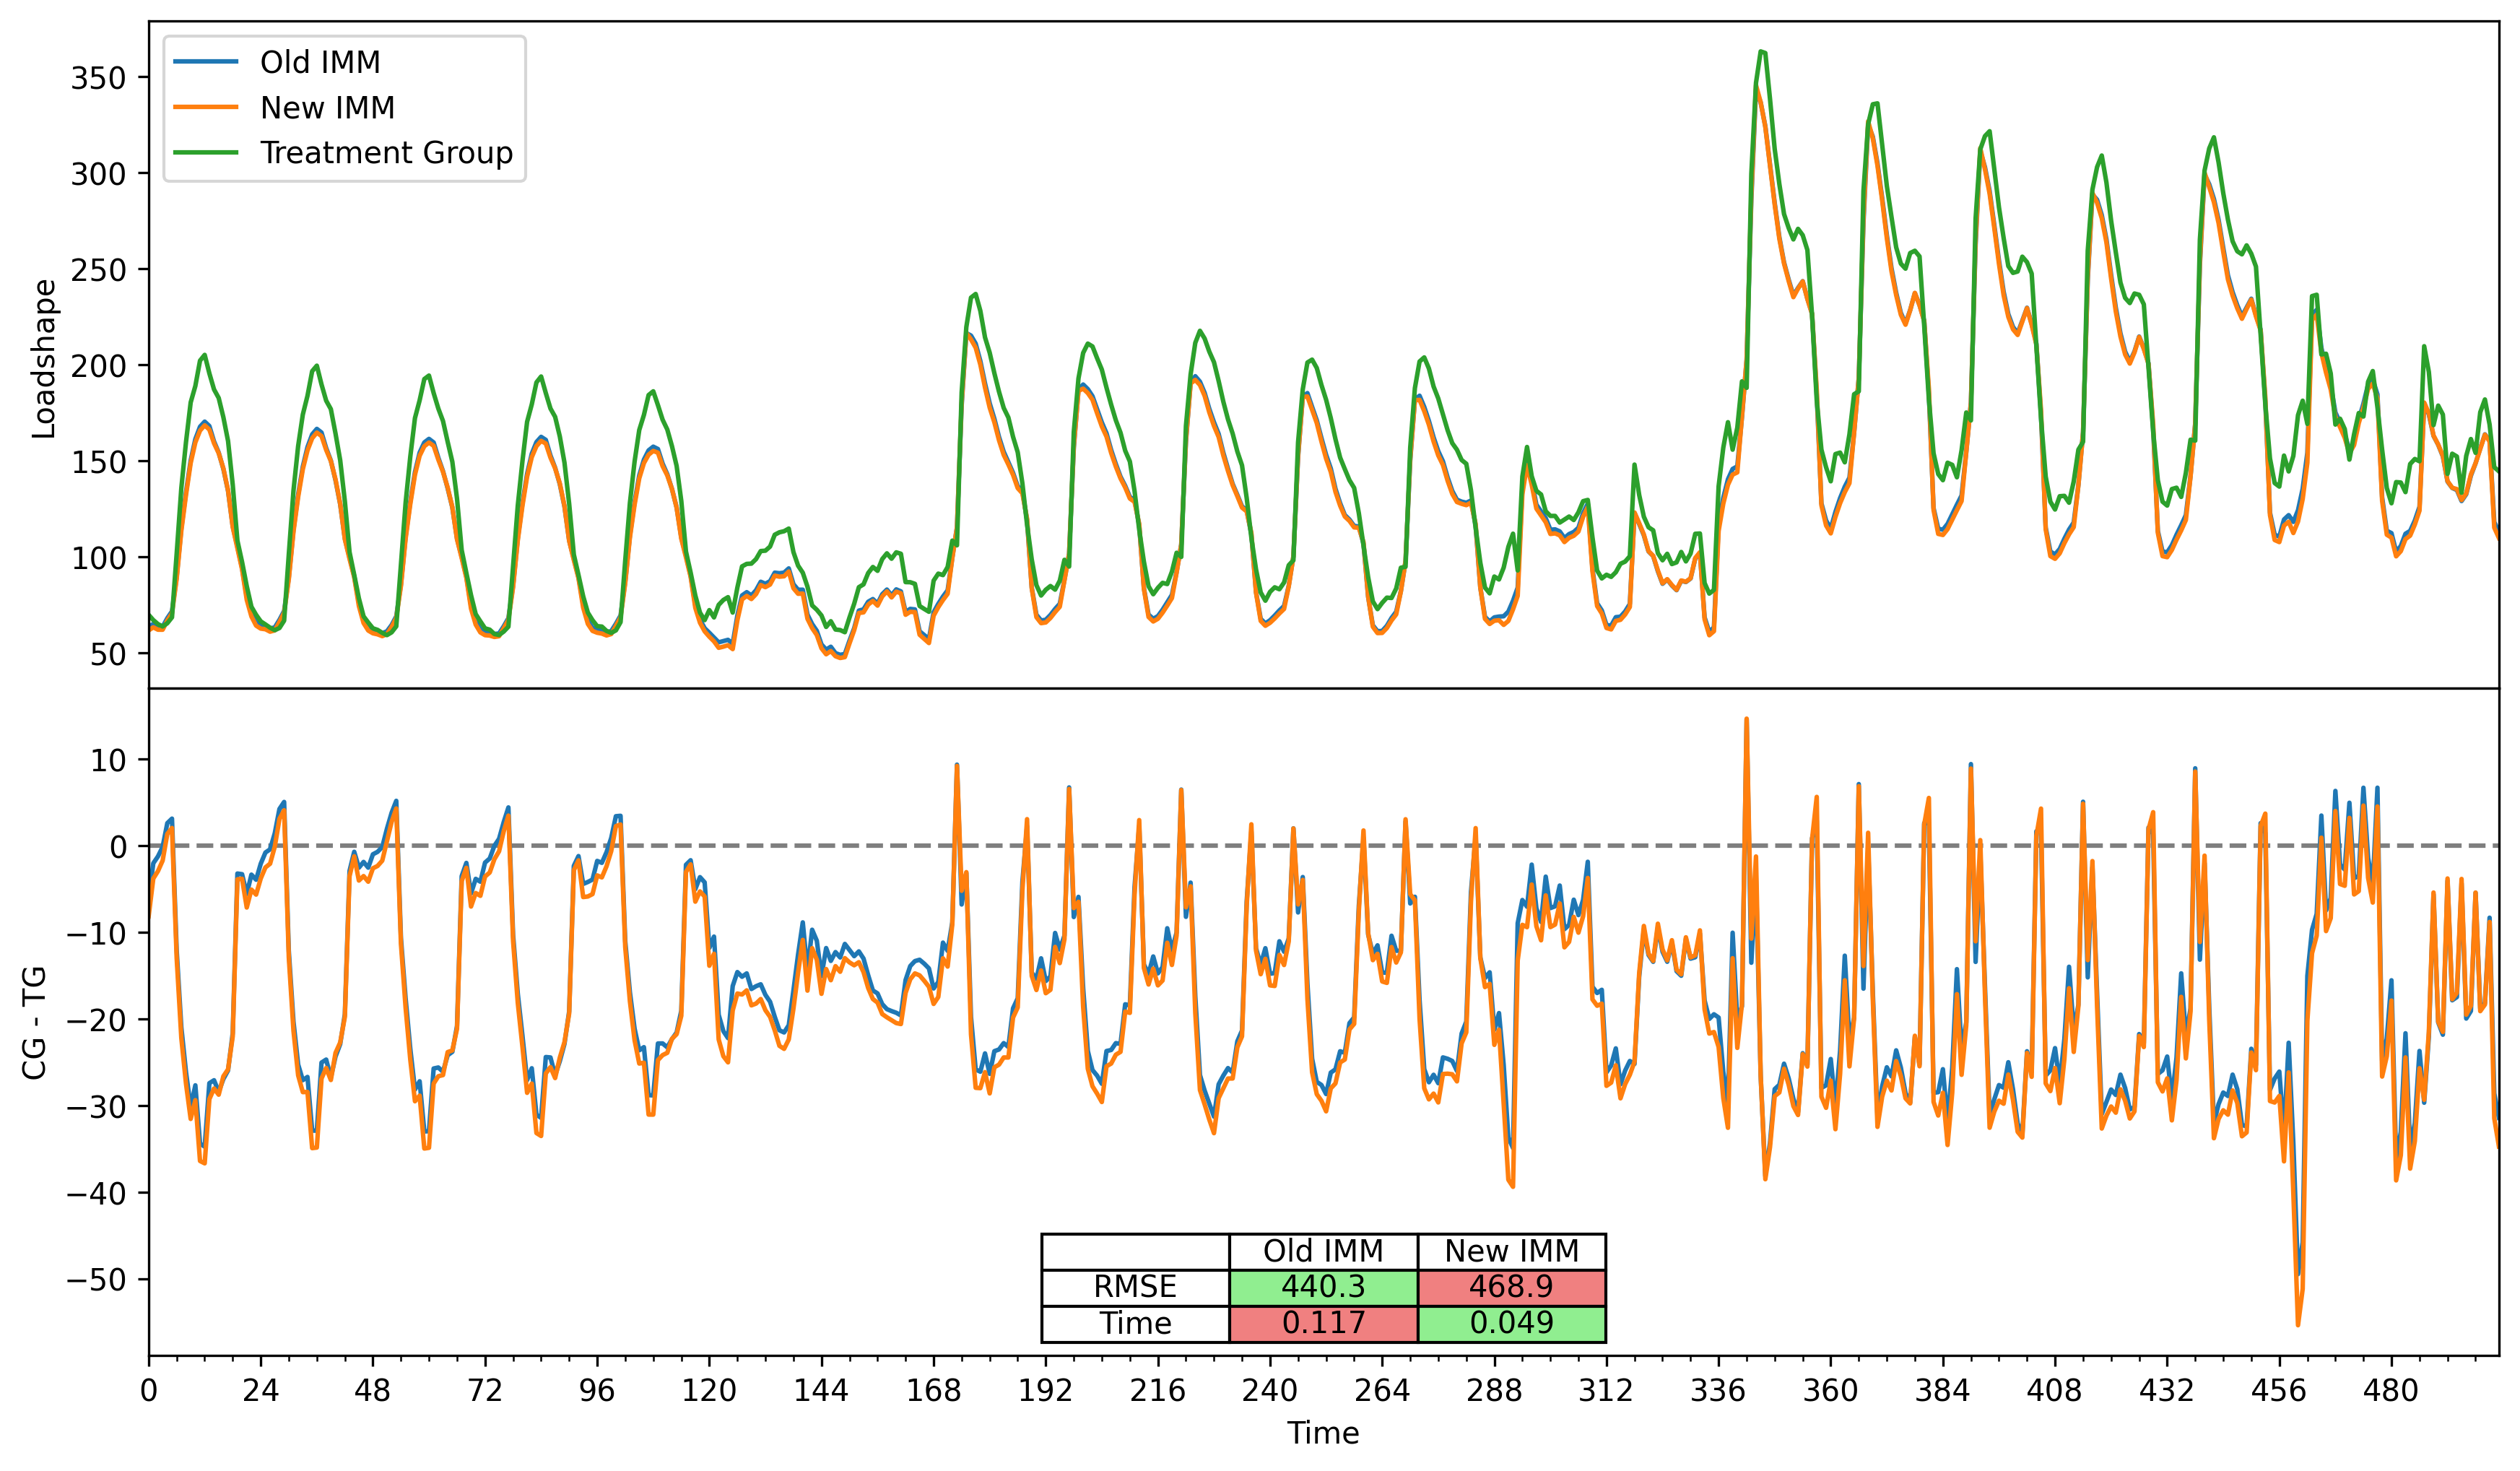

In [19]:
# treatment_data, pool_data = generate_data(df_ls_all)
# 
ls_old, df_cg_old, df_t_coeffs_old, old_time = fit_IMM(treatment_data, pool_data, method="legacy")
ls_new, df_cg_new, df_t_coeffs_new, new_time = fit_IMM(treatment_data, pool_data, method="minimize_meter_distance")
# ls_new, df_cg_new, df_t_coeffs_new, new_time = fit_IMM(treatment_data, pool_data, method="minimize_loadshape_distance")

# ls_old, df_cg_old, df_t_coeffs_old, old_time = fit_clustering(treatment_data, pool_data, method="custom")
# ls_new, df_cg_new, df_t_coeffs_new, new_time = fit_clustering(treatment_data, pool_data, method="highs")

# plot treatment group in ls_old and all of ls_new using matplotlib in one figure
t_min = ls_new.T.index[0]
t_max = ls_new.T.index[-1]

# plot ls
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), dpi=300)
plt.subplots_adjust(hspace=0)

ax1.plot(ls_old.T.index, ls_old.T["Comparison Group"], label="Old IMM")
ax1.plot(ls_new.T.index, ls_new.T["Comparison Group"], label="New IMM")
ax1.plot(ls_new.T.index, ls_new.T["Treatment Group"], label="Treatment Group")
# ax1.plot(ls_new.T.index, ls_new.T["Comparison Pool"], label="Comparison Pool", color="black", alpha=0.5)

ax1.set_xticks([])
ax1.set_ylabel('Loadshape')
ax1.legend()

# make ax2 plot the difference between the two loadshapes
ax2.axhline(0, linestyle="--", color="black", alpha=0.5)
ax2.plot(ls_new.T.index, ls_old.T["Comparison Group"] - ls_old.T["Treatment Group"], label="Old IMM")
ax2.plot(ls_new.T.index, ls_new.T["Comparison Group"] - ls_new.T["Treatment Group"], label="New IMM")

if (t_max - t_min) % 24 and (t_max - t_min) > 24:
    ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    ax2.set_xticks(np.arange(t_min, t_max, 24))

ax2.set_xlabel('Time')
ax2.set_ylabel('CG - TG')

ax1.set_xlim([t_min, t_max])
ax2.set_xlim([t_min, t_max])

# add RMSE to plot next to legend
# get y limits of ax2
y_min, y_max = ax2.get_ylim()
x_txt = (t_max-t_min)/2
y_txt = (y_max - y_min) * 0.9 + y_min

# compute rmse of ls_new old and new "treatment_group vs. comparison_group"
old_rmse = (np.sum((ls_old.loc["Comparison Group"] - ls_old.loc["Treatment Group"])**2))**0.5
new_rmse = (np.sum((ls_new.loc["Comparison Group"] - ls_new.loc["Treatment Group"])**2))**0.5

# plot table of RMSE and time using latex
table_data = [
    ["RMSE", round(old_rmse, 1), round(new_rmse, 1)],
    ["Time", round(old_time, 3), round(new_time, 3)]
]

width = 0.08
table = ax2.table(cellText=table_data, colLabels=["", "Old IMM", "New IMM"], cellLoc="center", loc=7, colWidths=[width]*3, zorder=99)

# color cell in RMSE row with green if new RMSE is lower
if new_rmse < old_rmse:
    table[(1, 1)].set_facecolor("lightcoral")
    table[(1, 2)].set_facecolor("lightgreen")
else:
    table[(1, 1)].set_facecolor("lightgreen")
    table[(1, 2)].set_facecolor("lightcoral")

if old_time > new_time:
    table[(2, 1)].set_facecolor("lightcoral")
    table[(2, 2)].set_facecolor("lightgreen")
else:
    table[(2, 1)].set_facecolor("lightgreen")
    table[(2, 2)].set_facecolor("lightcoral")

print(f"{df_cg_old['distance'].sum() - df_cg_new['distance'].sum():.1f}")

fig.show()

In [ ]:
df_cg_new["duplicated"].unique()

In [ ]:
from scipy import sparse
from qpsolvers import solve_ls, available_solvers
from gridmeter.individual_meter_matching.settings import HiGHS_Settings

from scipy.spatial.distance import cdist

from gridmeter.clustering.treatment_fit import _match_treatment_to_cluster

print(available_solvers)

In [ ]:
def match_treatment(t_ls, cp_ls, coef_sum=1, x0=None, solver="highs", settings=None, verbose=False):
    if settings is None:
        settings = HiGHS_Settings(
            PRIMAL_FEASIBILITY_TOLERANCE=1E-4, 
            DUAL_FEASIBILITY_TOLERANCE=1E-4, 
        )
        settings = {k.lower(): v for k, v in dict(settings).items()}

    num_pool_meters = cp_ls.shape[0]

    R = sparse.csc_matrix(cp_ls.T)

    h = np.zeros(num_pool_meters)
    eye = sparse.eye(num_pool_meters, format="csc")
    A = sparse.csc_matrix(np.ones(num_pool_meters))
    b = np.array([coef_sum])

    lb = np.zeros(num_pool_meters)
    ub = np.ones(num_pool_meters)

    x = solve_ls(R, t_ls, G=-eye, h=h, A=A, b=b, lb=lb, ub=ub, solver=solver, verbose=verbose, **settings)

    return x

t_n = 0
solvers = ['custom', 'clarabel', 'cvxopt', 'daqp', 'ecos', 'highs', 'osqp', 'piqp', 'proxqp', 'qpalm', 'quadprog', 'scs']

highs_settings = HiGHS_Settings(
    # PRIMAL_FEASIBILITY_TOLERANCE=1E-4, 
    # DUAL_FEASIBILITY_TOLERANCE=1E-4, 
)
highs_settings_dict = {k.lower(): v for k, v in dict(highs_settings).items()}

solver_config = {
    "custom": gm.Clustering_Settings(AGG_TYPE="mean"),
    "highs": highs_settings_dict,
    # "clarabel": {
    #     "tol_gap_abs": 1E-3,
    #     "tol_gap_rel": 1E-4,
    #     "tol_feas": 1E-7
    # },
}

ls_pool = pool_data.loadshape.values
ls_treat = treatment_data.loadshape.iloc[t_n].values

ls_cg_fit = []
for solver, settings in solver_config.items():
    if solver == "custom":
        t_meter = treatment_data.loadshape.iloc[t_n].to_frame().T

        start = timer()
        x_opt = _match_treatment_to_cluster(t_meter, pool_data.loadshape, settings).values
        time = timer() - start

    else:
        start = timer()
        x_opt = match_treatment(ls_treat, ls_pool, solver=solver, settings=settings)
        time = timer() - start
        
        # try:
        #     start = timer()
        #     x_opt = match_treatment(ls_treat, ls_pool, x0=x0, solver=solver, **settings)
        #     time = timer() - start

        # except:
        #     print(f"{solver:<8s}")
        #     continue

    x_opt[x_opt < 0] = 0
    x_opt[x_opt > 1] = 1
    x_opt[np.abs(x_opt) < 1E-6] = 0
    x_opt /= x_opt.sum()

    ls_cg = np.sum(ls_pool.T*x_opt, axis=1)
    ls_cg_fit.append([solver, ls_cg])

    res = ls_cg - ls_treat
    rmse = np.sqrt(np.sum(res**2))

    # print w with 3 decimal places
    with open("test.txt", "a") as f:
        f.write(f"{solver:<8s} {rmse:>8.1f} {x_opt.min():>8.2f} {time:>6.1f}\n")
        
    print(f"{solver:<8s} {rmse:>8.1f} {x_opt.min():>8.2f} {time:>6.1f}")